In [50]:
import hdbscan
import pandas as pd
import numpy as np
%matplotlib ipympl
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn import manifold
import os
import json
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

In [2]:
MATERIAL_PATH = "../All_mat_new_test_score_with_horz_flat_index.csv"
#DATA_PATH = "../../data"

# "henry's local data path"
DATA_PATH = "../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA"

In [3]:
material_df = pd.read_csv("../All_mat_new_test_score_with_horz_flat_index.csv", index_col="ID")
print(material_df.shape)
material_df.head()

(5270, 24)


formula gen_formula  space_group  segments  flat_segments  flatness_score  discovery  ...    D   E   F            radio            f_orb sg_sto_group percentage_flat
ID                                                                                          ...                                                                            
2dm-1    IrF2         AB2          164         3              0        0.095102  bottom-up  ...  NaN NaN NaN  non-radioactive  no-f-in-valence          NaN             NaN
2dm-2   Ba2Sb         AB2          164         3              1        0.387410  bottom-up  ...  NaN NaN NaN  non-radioactive  no-f-in-valence          NaN             NaN
2dm-3     TlS          AB            2         4              4        0.846460  bottom-up  ...  NaN NaN NaN  non-radioactive  no-f-in-valence        276.0            24.2
2dm-4   MoCl2         AB2          166         5              4        0.713760  bottom-up  ...  NaN NaN NaN  non-radioactive  no-f-in-valence          NaN             NaN
2dm-6    RuI2         AB2          164         3              1        0.264930  bottom-up  ...  NaN NaN NaN  non-radioactive  no-f-in-valence          NaN             NaN

[5 rows x 24 columns]

In [4]:
# Select flat materials only
flat_df = material_df[material_df.horz_flat_seg > 0]
flat_df.shape

(2005, 24)

In [5]:
def calc_fingerprint(material_id, fingerprint_length, e_range=[-8, 8]):
    global edges
    filename_bands=DATA_PATH+"/bands/"+material_id+'.json'
    if not os.path.isfile(filename_bands):
        print("!!!! No such file %s" % filename_bands)
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]
        # print(i, branch_energies)
        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range)
        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint
    

fp = calc_fingerprint("2dm-1", 60)
plt.plot(fp)
fp

!!!! No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/bands/2dm-1.json


FileNotFoundError: [Errno 2] No such file or directory: '../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/bands/2dm-1.json'

In [ ]:
# re-run with all materials using this line
#flat_df = material_df

fingerprint_length = 60
finger_print_array = np.zeros([len(flat_df), fingerprint_length])

In [ ]:
for i, material_id in enumerate(flat_df.index):
    if i % 100 == 0:
        print(i, "/", len(flat_df))

    finger_print_array[i, :] = calc_fingerprint(material_id, fingerprint_length)

print(finger_print_array)

In [ ]:
df = flat_df.join(pd.DataFrame(finger_print_array, index=flat_df.index))
df.head()

In [ ]:
#check for NaNs 
np.isnan(finger_print_array).sum()

In [ ]:
df.isna().sum()[ df.isna().sum() != 0 ]

In [ ]:
# save df
# df.to_csv("materials_data_whole_database_all_k_branches_fingerprint_60.csv")

## Clustering

In [51]:
fingerprint_length = 60
df = pd.read_csv(f"materials_data_whole_database_all_k_branches_fingerprint_{fingerprint_length}.csv")
fingerprint_cols = [str(i) for i in range(fingerprint_length)]
fingerprint_array = df[fingerprint_cols]

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=4, p=0.2)
clusterer.fit(fingerprint_array)

labels = clusterer.labels_
df["labels"] = labels
print(np.unique(labels, return_counts=True))
df[df.labels==1].head(19)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105]), array([4453,    8,    5,   14,    7,    7,    6,    6,    5,    7,    4,
          6,    8,    4,    6,   14,    4,    7,    8,    8,    9,    8,
         11,    8,    5,    4,    5,    4,   10,   12,    8,   13,    8,
          4,    4,    5,    4,    6,    5,    4,    4,    4,    8,    5,
         11,    7,    5,    5,    4,    9,   11,    6,    5,    5,    5,
          5,   10,    9,    4,    

ID formula gen_formula  space_group  segments  flat_segments  flatness_score  ...     54     55    56   57   58   59 labels
835    2dm-900   Ga2Te         AB2          143         3              3         0.78315  ...  398.0  224.0   0.0  0.0  0.0  0.0      1
838    2dm-903   Ga2Te         AB2          143         3              3         0.81656  ...  390.0  219.0   0.0  0.0  0.0  0.0      1
843    2dm-910   Ga2Se         AB2          143         3              3         0.87920  ...  343.0  276.0   0.0  0.0  0.0  0.0      1
1641  2dm-1777    Ga2S         AB2          143         3              3         0.87920  ...  319.0  309.0  91.0  0.0  0.0  0.0      1
1656  2dm-1794    Ga2S         AB2          143         3              3         0.84263  ...  331.0  305.0  70.0  0.0  0.0  0.0      1

[5 rows x 86 columns]

interactive(children=(IntSlider(value=52, description='label', max=105, min=-1), Output()), _dom_classes=('wid…

<function __main__.view_cluster(label)>

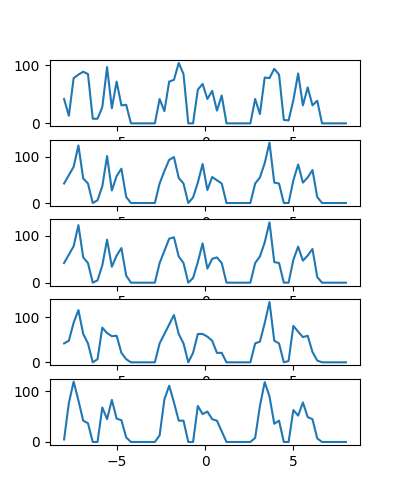

In [52]:
from ipywidgets import interact

def view_cluster(label):
    display(df[df.labels==label].head(100))

    num_plots = len(df[df.labels==label])

    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        # ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])?
        ax[i].plot(np.linspace(-8, 8, fingerprint_length), df.loc[index][fingerprint_cols])


    
    
interact(view_cluster, label=(-1, len(np.unique(labels))-2, 1))

## T-SNE Plot

In [8]:
n_components=2
tsne = manifold.TSNE(n_components=n_components, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
fingerprints_2d = tsne.fit_transform(fingerprint_array)

df["fx"] = fingerprints_2d[:,0]
df["fy"] = fingerprints_2d[:,1]
df.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5270 samples in 0.003s...
[t-SNE] Computed neighbors for 5270 samples in 0.417s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5270
[t-SNE] Computed conditional probabilities for sample 2000 / 5270
[t-SNE] Computed conditional probabilities for sample 3000 / 5270
[t-SNE] Computed conditional probabilities for sample 4000 / 5270
[t-SNE] Computed conditional probabilities for sample 5000 / 5270
[t-SNE] Computed conditional probabilities for sample 5270 / 5270
[t-SNE] Mean sigma: 73.408827
[t-SNE] Computed conditional probabilities in 0.264s
[t-SNE] Iteration 50: error = 82.3743591, gradient norm = 0.0132815 (50 iterations in 1.616s)
[t-SNE] Iteration 100: error = 79.1293793, gradient norm = 0.0019983 (50 iterations in 1.593s)
[t-SNE] Iteration 150: error = 78.8312378, gradient norm = 0.0004368 (50 iterations in 1.319s)
[t-SNE] Iteration 200: error = 78.7757874, gradient norm = 0.0001571 (50 iterations in 1.573s)
[

/tmp/ipykernel_23297/3455338055.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('turbo')


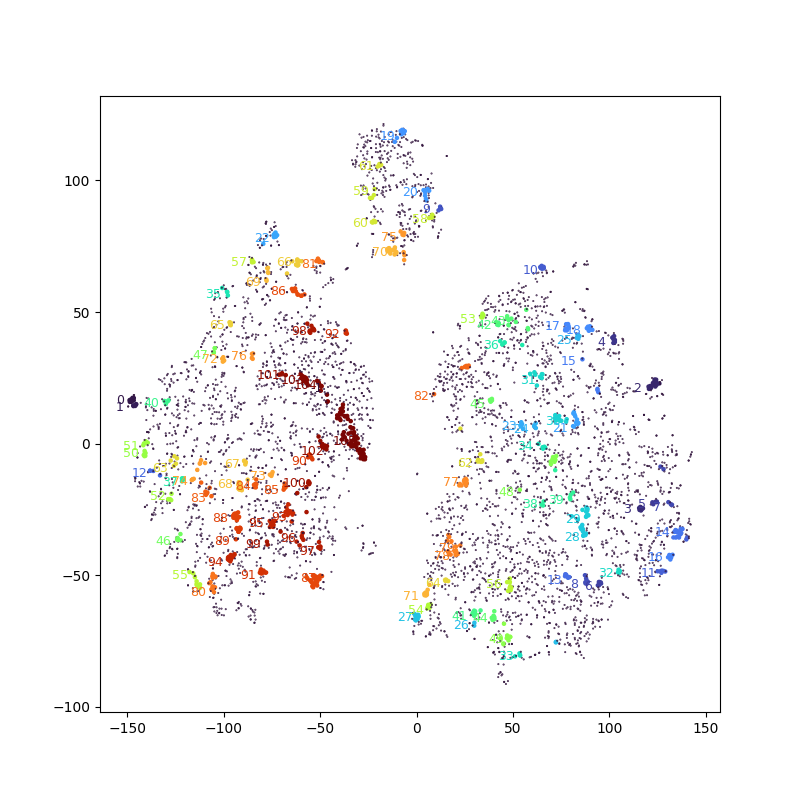

In [54]:
fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprints_2d[rep_id,:]+[-7,-1],color=col,alpha=1, weight='normal', ha='center', va='center', size=9).draggable()

plt.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=size, c=labels*5, cmap="turbo")

In [11]:
# Import libraries
import matplotlib.patches as mpatches

# Creating legend with color box
color_patch = mpatches.Patch(color='red', label='legend')
plt.legend(handles=[color_patch])

In [12]:
def get_color(df, elements, columns=["A", "B", "C", "D", "E", "F"]):
    # create a black colour array [r, g, b, alpha]
    color_array = np.zeros((len(df), 4))
    color_array[:, 3] = 1

    # get a color for each element
    colors = plt.cm.rainbow(np.linspace(0, 0.95, len(elements)))

    # create a legend handle array 
    legend_handles = []
        
    for color, element in zip(colors, elements):
        color_array[ (df[columns]==element).any(axis=1) ] = color # non-zero is any elements are in list
        legend_handles.append(mpatches.Patch(color=color, label=element))

    return color_array, legend_handles

get_color(df, ["Ca", "Na"])

(array([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]),
  <matplotlib.patches.Patch at 0x7f07a65b5d90>])

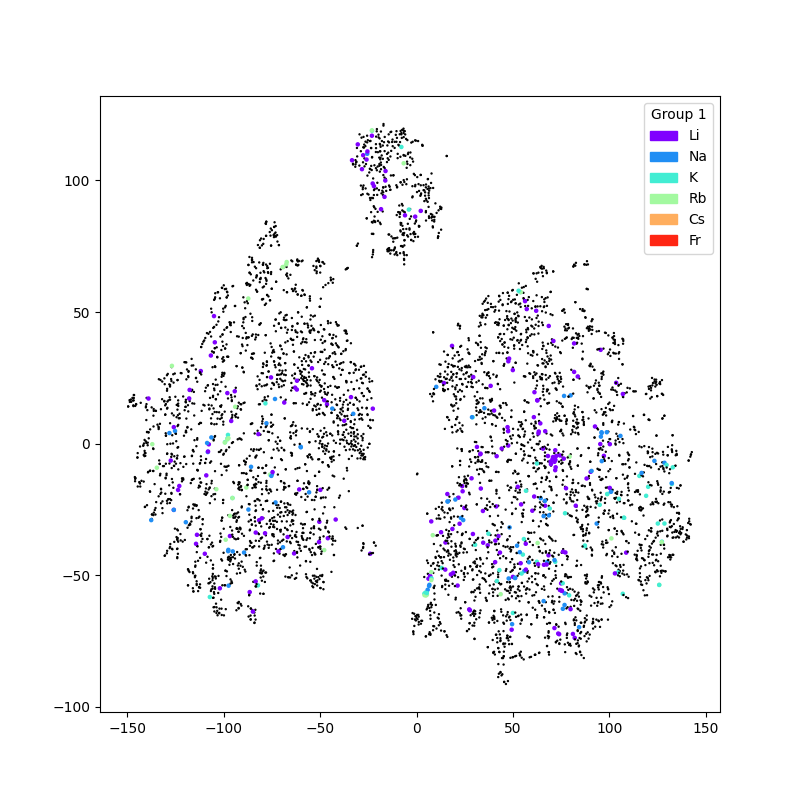

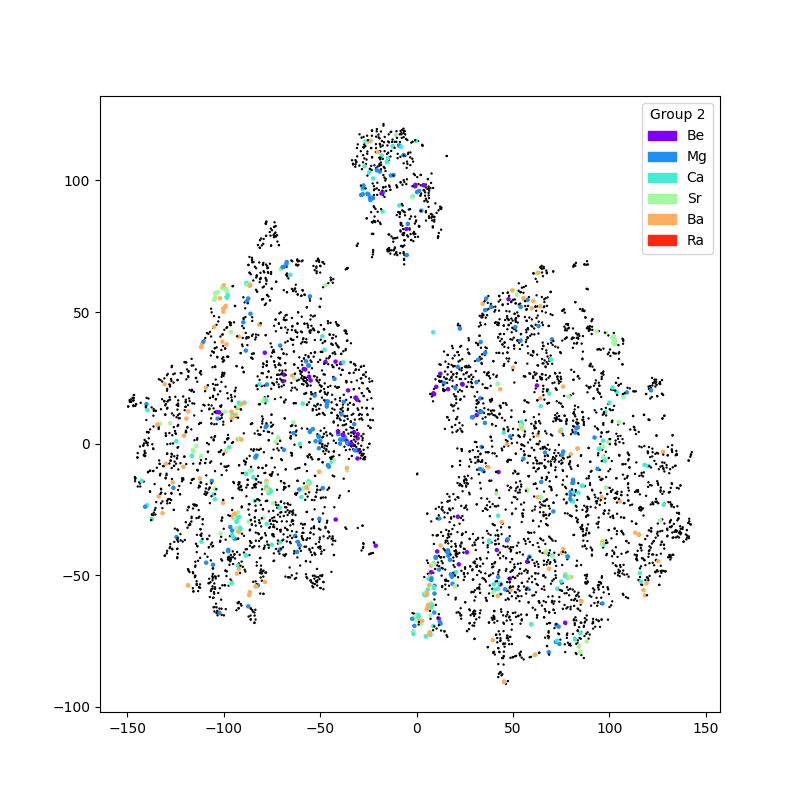

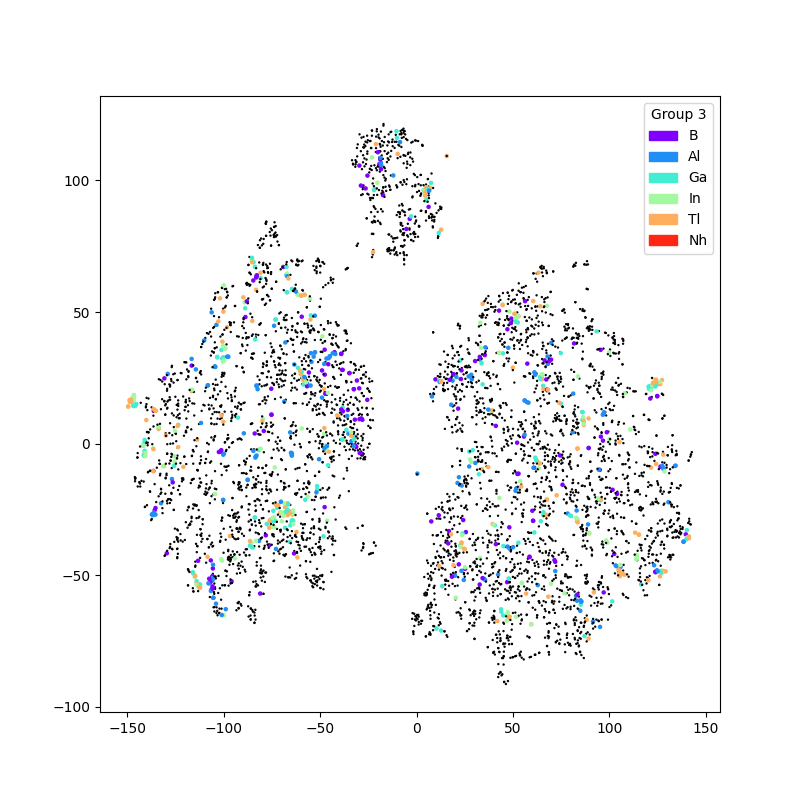

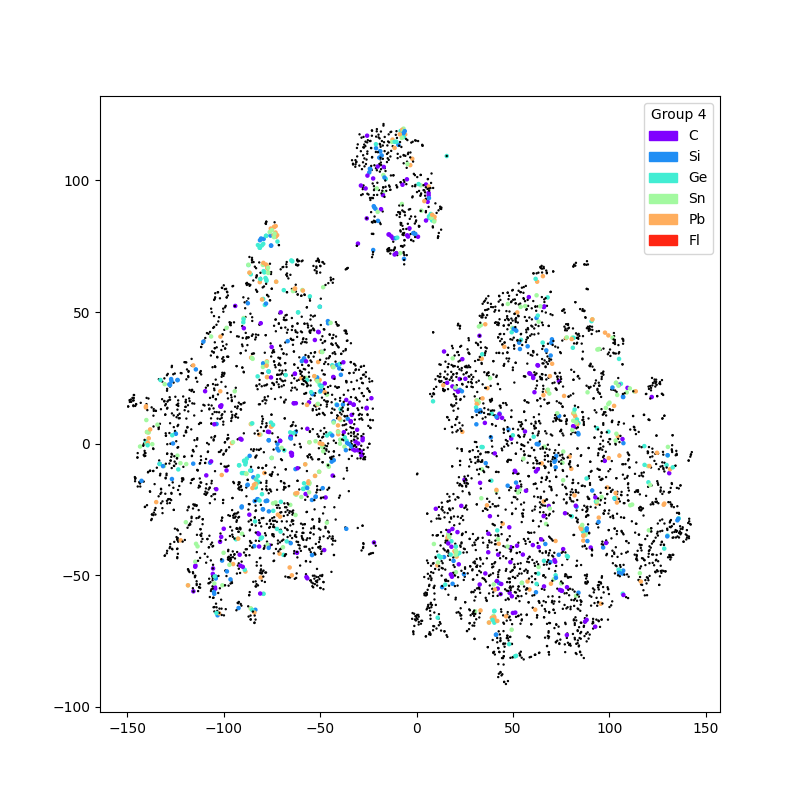

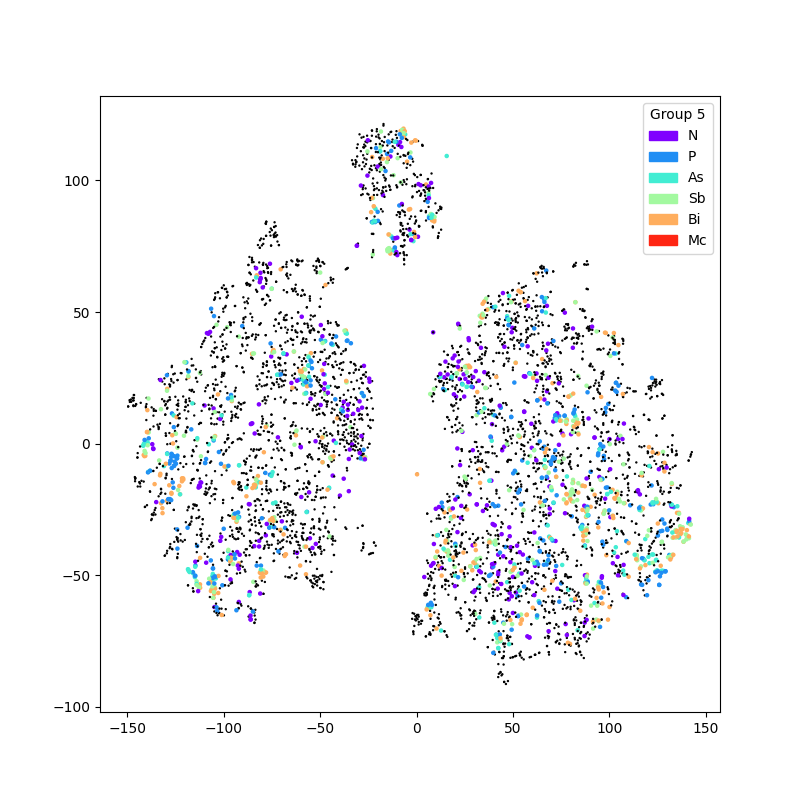

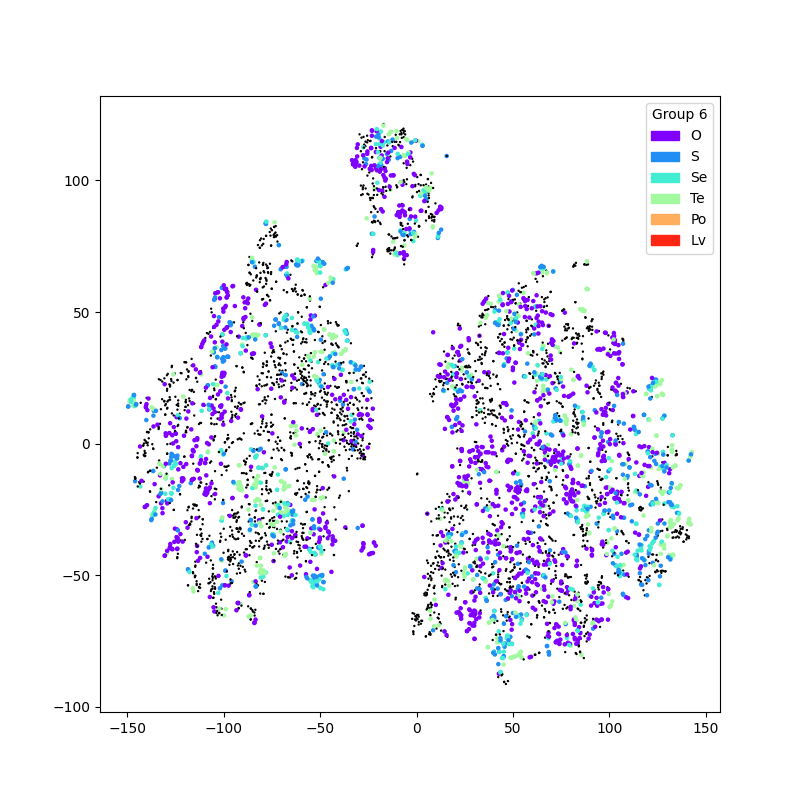

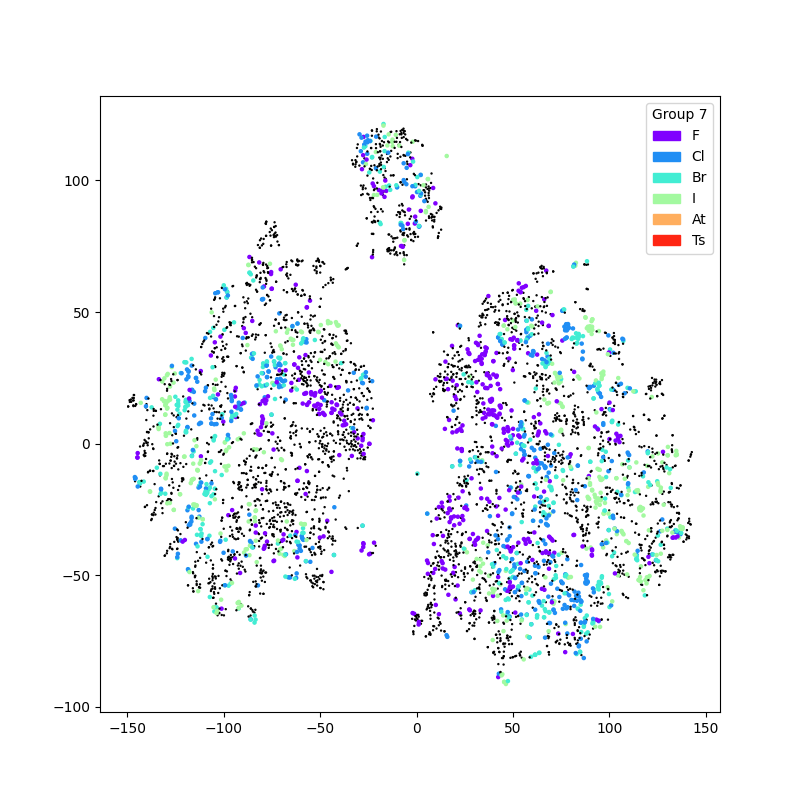

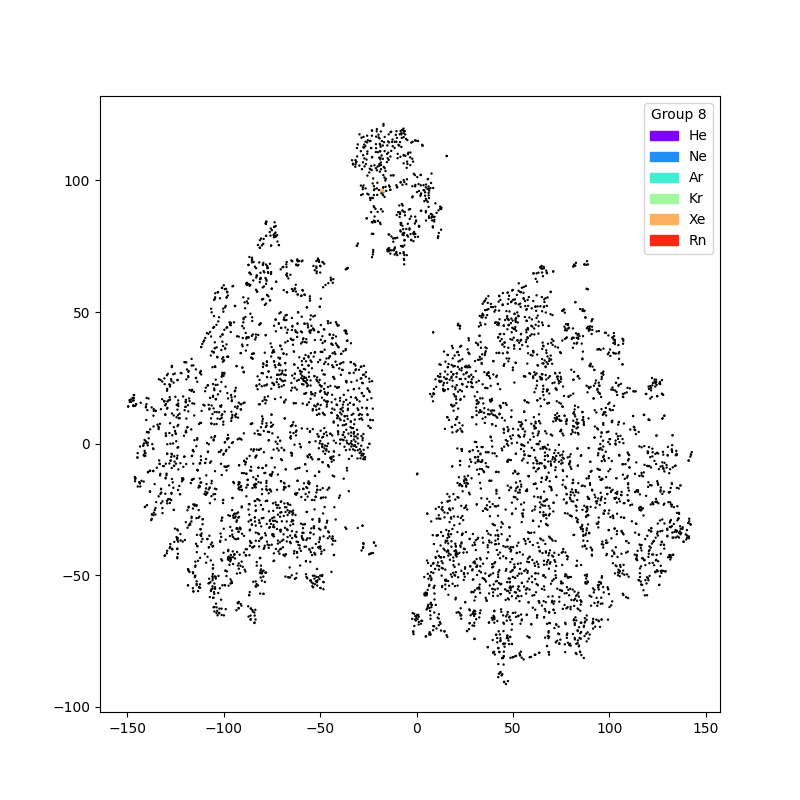

In [13]:
groups = {
"Group 1" : ["Li", "Na", "K", "Rb", "Cs", "Fr"],
"Group 2" : ["Be", "Mg", "Ca", "Sr", "Ba", "Ra"],
"Group 3" : ["B", "Al", "Ga", "In", "Tl", "Nh"],
"Group 4" : ["C", "Si", "Ge", "Sn", "Pb", "Fl"],
"Group 5" : ["N", "P", "As", "Sb", "Bi", "Mc"],
"Group 6" : ["O", "S", "Se", "Te", "Po", "Lv"],
"Group 7" : ["F", "Cl", "Br", "I", "At", "Ts"],
"Group 8" : ["He", "Ne", "Ar", "Kr", "Xe", "Rn"],
}

def scatter_plot(legend_title, elements, columns=["A", "B", "C", "D", "E", "F"]):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    color, legend_handles = get_color(df, elements, columns=columns)
    
    size = pd.Series(index=df.index)
    size = np.where(np.equal([0, 0, 0, 1], color).all(axis=1), 0.5, 5)
    
    
    ax.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=size, c=color)
    ax.legend(title=legend_title, handles=legend_handles)
    plt.show()

for group in groups:
    scatter_plot(group, groups[group])


In [14]:
space_groups = np.unique(df.space_group, return_counts=True)
space_groups

(array([  1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,
         17,  18,  21,  25,  26,  28,  29,  30,  31,  32,  35,  38,  39,
         42,  47,  49,  50,  51,  53,  54,  55,  57,  59,  63,  65,  67,
         69,  75,  81,  83,  85,  90,  99, 111, 113, 115, 123, 125, 127,
        129, 139, 143, 147, 149, 150, 156, 157, 160, 162, 164, 166, 174,
        183, 187, 189, 191]),
 array([280, 316,  10,  54,  70,  59,  79,  55, 129, 303, 309,  94, 245,
         13,   7,  20,  47, 154,   4,  12,   5, 103,   1,   1,  13,  14,
          2,  96,   5,   2, 184,  22,   5,  11,  44, 195,   1,  16,  14,
          1,   1,   3,   1,  22,   6,  30,   8,   7,  75, 266,  32,  51,
        340,   1,  30,  58,  13,  11, 144,  15,   1, 102, 688,   7,   6,
          3, 217,  17, 120]))

In [15]:
#scatter_plot("Space Group", space_groups, columns=["space_group", "A"])
scatter_plot_interactive = lambda x: scatter_plot("Space Group", [x], columns=["space_group", "A"])

interact(scatter_plot_interactive, x=np.unique(df.space_group))

interactive(children=(Dropdown(description='x', options=(1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 2…

<function __main__.<lambda>(x)>

In [55]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

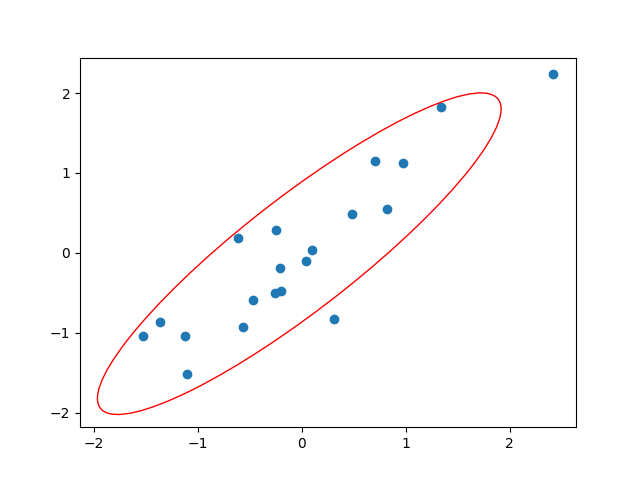

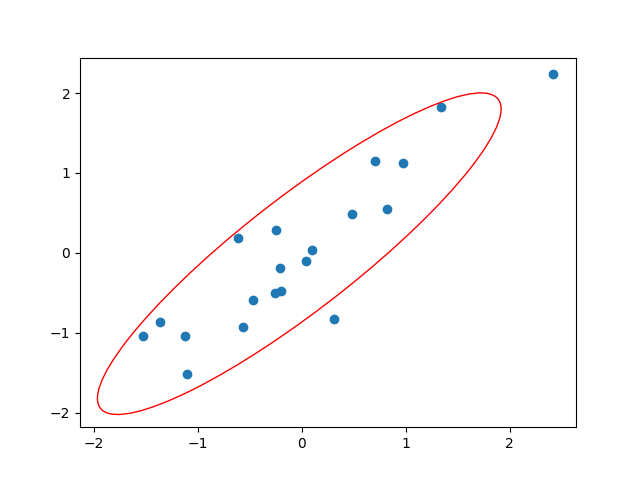

In [56]:
fig, ax = plt.subplots()
plt.scatter(data[:, 0], data[:, 1])
confidence_ellipse(data[:, 0], data[:, 1], ax, edgecolor='red', n_std=2)
fig.show()

/tmp/ipykernel_23297/1203595185.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('turbo')
/tmp/ipykernel_23297/1203595185.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cet_glasbey')
/tmp/ipykernel_23297/1203595185.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legmarker, origscatter in zip(leg.legendHandles, scatters):


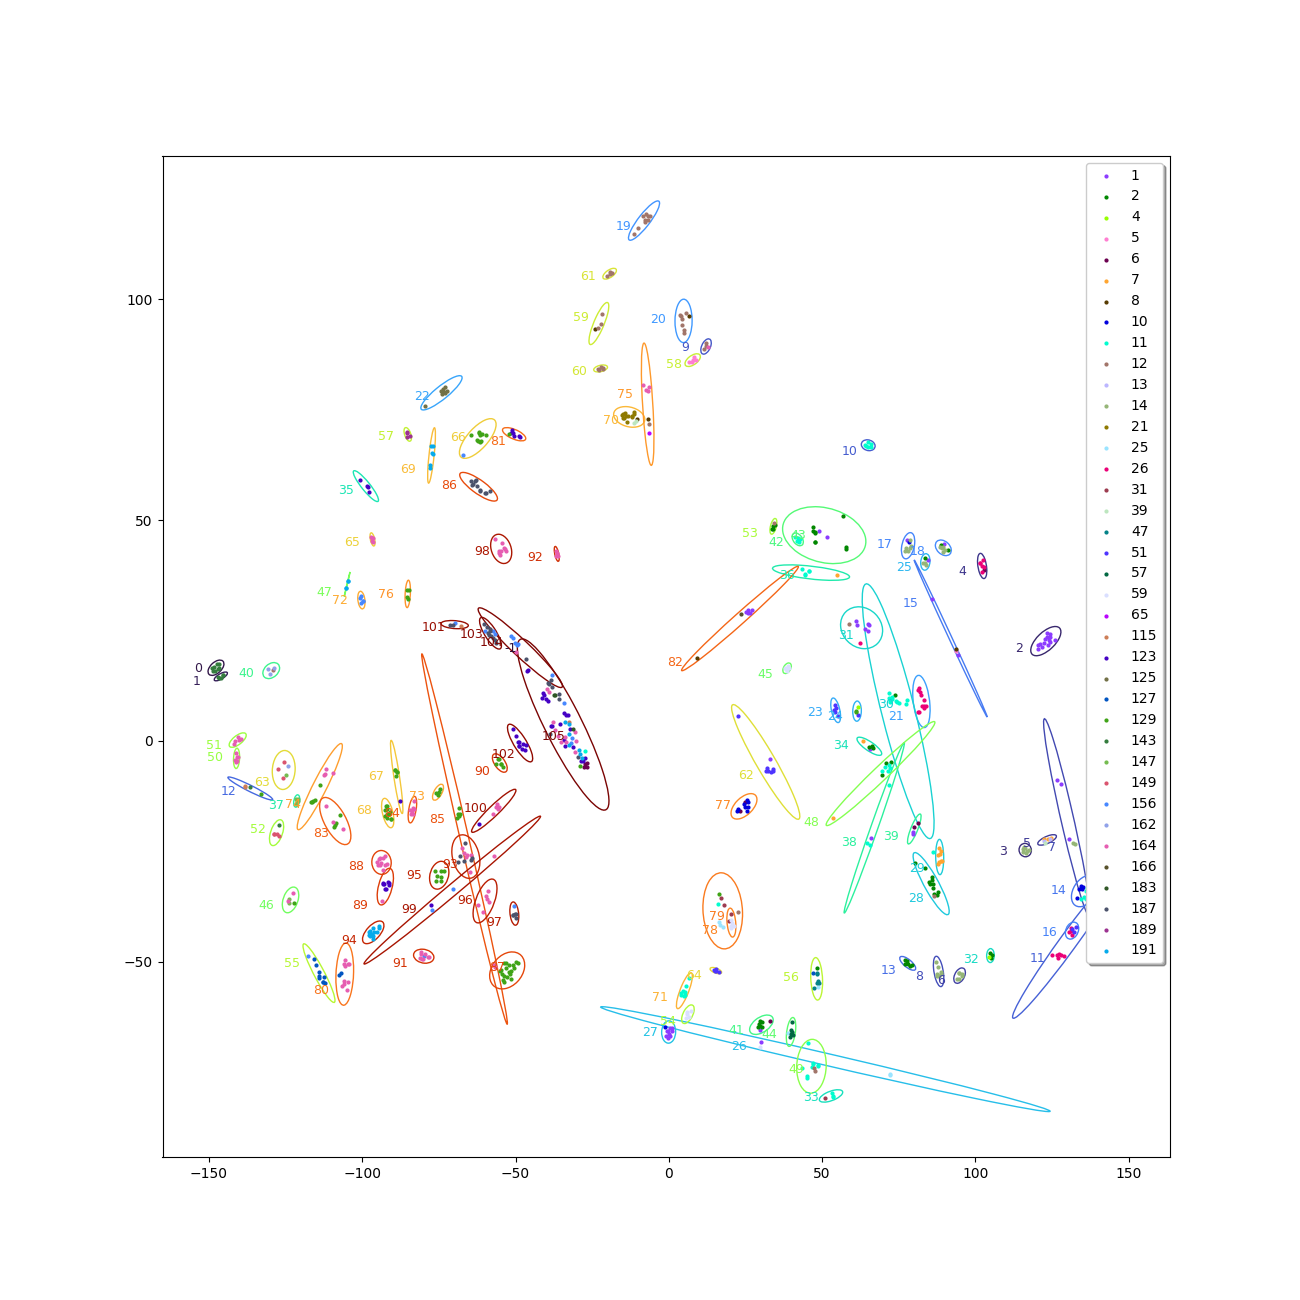

In [59]:
import colorcet as cc

fig,ax  = plt.subplots(figsize=(13,13))
 
unique_label,cluster_rep_index, counts = np.unique(df.labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(df.labels), vmax=max(df.labels))
    
for label, rep_id in zip(unique_label, cluster_rep_index):
    col=cmap(norm(labels[rep_id]))
    ax.annotate(labels[rep_id],df[["fx", "fy"]].iloc[rep_id]+[-7,-1],color=col,alpha=1, weight='normal', ha='center', va='center', size=9).draggable()

    if label != -1:
        cluster_x_y = fingerprints_2d[labels==label]
        confidence_ellipse(cluster_x_y[:, 0], cluster_x_y[:, 1], ax, edgecolor=col, n_std=3)

df_clustered = df[df.labels != -1]
space_groups = np.unique(df_clustered.space_group)

norm = matplotlib.colors.Normalize(vmin=0, vmax=len(space_groups))
cmap = plt.cm.get_cmap('cet_glasbey')

scatters = []

for i, space_group in enumerate(space_groups):
    indices = df_clustered.space_group==space_group
    col=cmap(norm(space_group))
    scatter = ax.scatter(df_clustered.fx[indices], df_clustered.fy[indices],s=4, c=cc.glasbey[space_group], label=space_group)
    scatters.append(scatter)

leg = ax.legend(fancybox=True, shadow=True)

scatter_dict = {}  # Will map legend scatter markers to original scatter plots.

for legmarker, origscatter in zip(leg.legendHandles, scatters):
    legmarker.set_picker(True)  # Enable picking on the legend marker.
    scatter_dict[legmarker] = origscatter

# Include legend text in the legend_handles list
legend_texts = [text for text in leg.get_texts()]

# Add legend text to the dictionary
for legend_text, origscatter in zip(legend_texts, scatters):
    legend_text.set_picker(True)  # Enable picking on the legend text.
    scatter_dict[legend_text] = origscatter


def on_pick(event):
    # On the pick event, find the original scatter plot corresponding to the legend marker or text,
    # and toggle its visibility.
    legend_item = event.artist
    origscatter = scatter_dict[legend_item]
    origscatter.set_visible(not origscatter.get_visible())

    # Toggle the alpha for the legend marker and text.
    if isinstance(legend_item, plt.Text):
        legend_marker = leg.legendHandles[legend_texts.index(legend_item)]
        legend_marker.set_alpha(1.0 if origscatter.get_visible() else 0.2)
    else:
        legend_text = leg.get_texts()[leg.legendHandles.index(legend_item)]
        legend_text.set_alpha(1.0 if origscatter.get_visible() else 0.2)

    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)
plt.show()